In [1]:
# Importing libraries
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as t
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the ResNet-50 Model

In [ ]:
# load the model
model = models.resnet50(pretrained=True)
# print(model)
model_weights = []  # we will save the conv layer weights in this list
conv_layers = []  # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [3]:
# counter to keep count of the conv layers
counter = 0
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:  # if the layer is conv layer
        counter += 1  # increment the counter
        model_weights.append(model_children[i].weight)  # append the weights
        conv_layers.append(model_children[i])  # append the conv layer
    elif type(model_children[i]) == nn.Sequential:  # if the layer is sequential
        for j in range(
            len(model_children[i])
        ):  # iterate over the layers in the sequential
            for child in model_children[i][
                j
            ].children():  # iterate over the children of the layer
                if type(child) == nn.Conv2d:  # if the child is conv layer
                    counter += 1  # increment the counter
                    model_weights.append(child.weight)  # append the weights
                    conv_layers.append(child)  # append the conv layer
print(f"Total convolutional layers: {counter}")  # print the total number of conv layers


Total convolutional layers: 49


## Visualizing Convolutional Layer Filters

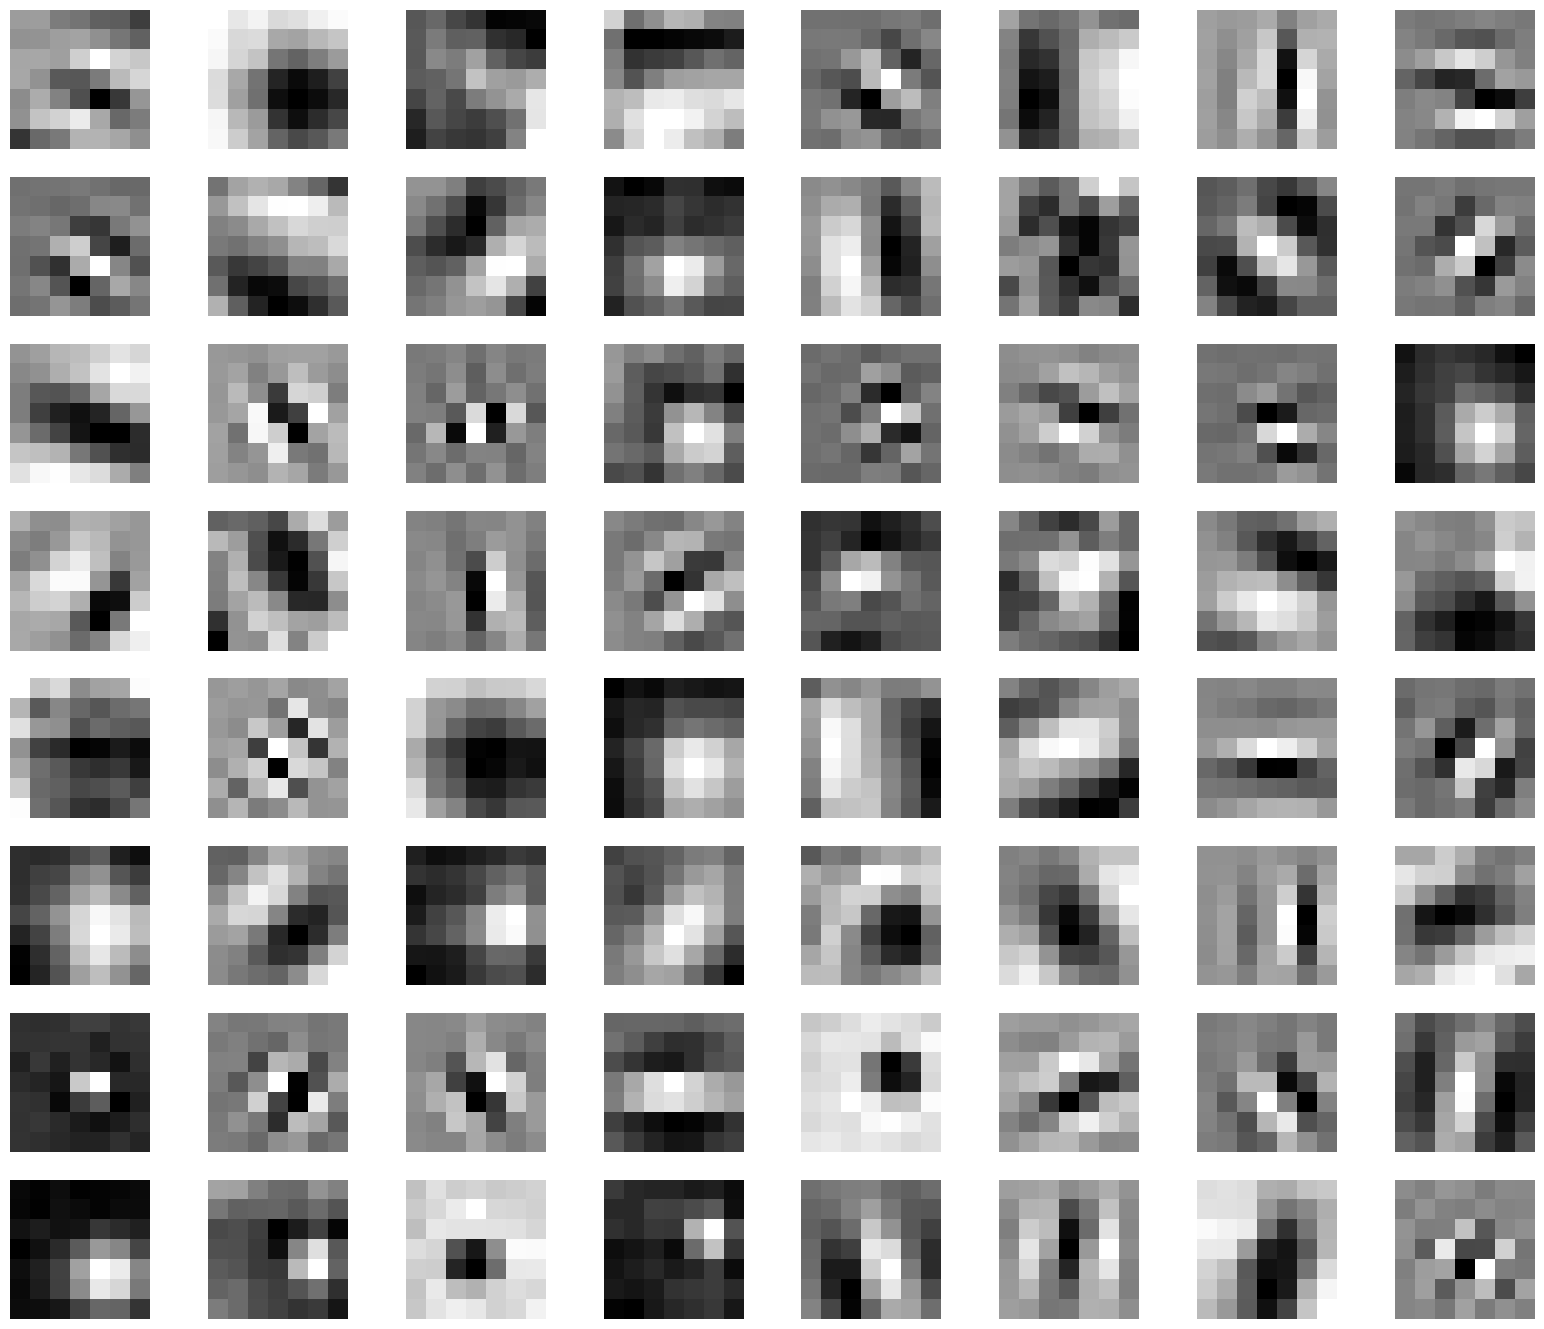

In [4]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(
        8, 8, i + 1
    )  # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap="gray")
    plt.axis("off")
    # plt.savefig('../outputs/filter.png')
plt.show()

## Visualizing the Feature Maps of the Convolutional Layers

### Reading the Image and Defining the Transforms

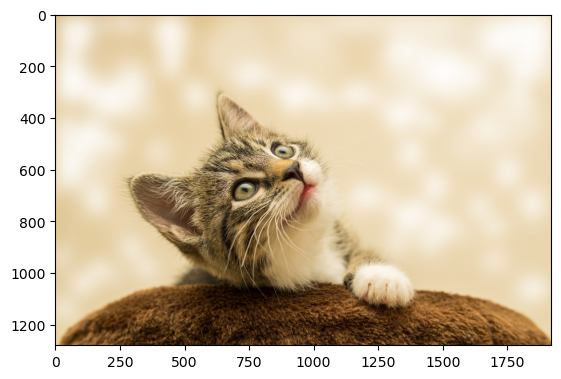

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


In [5]:
# read and visualize an image
img = cv.imread(f"../pics/cat.jpg") # read the image
img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # convert from BGR to RGB
plt.imshow(img) # plot the image
plt.show() # show the image 
# define the transforms
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ]
) # resize all the images to 512x512 and convert them to tensors
img = np.array(img) # convert the image to a numpy array
# apply the transforms
img = transform(img) 
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

### Passing the Input Image Through Each Convolutional Layer

In [6]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [7]:
def visualize_deep(outputs, index): # index is the layer number
    plt.figure(figsize=(15, 15)) # set the figure size
    layer_viz = outputs[index][0, :, :, :].data
    for i, filter in enumerate(layer_viz):
        if i == 64:  # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)  
        plt.imshow(filter, cmap="gray")
        plt.axis("off") 

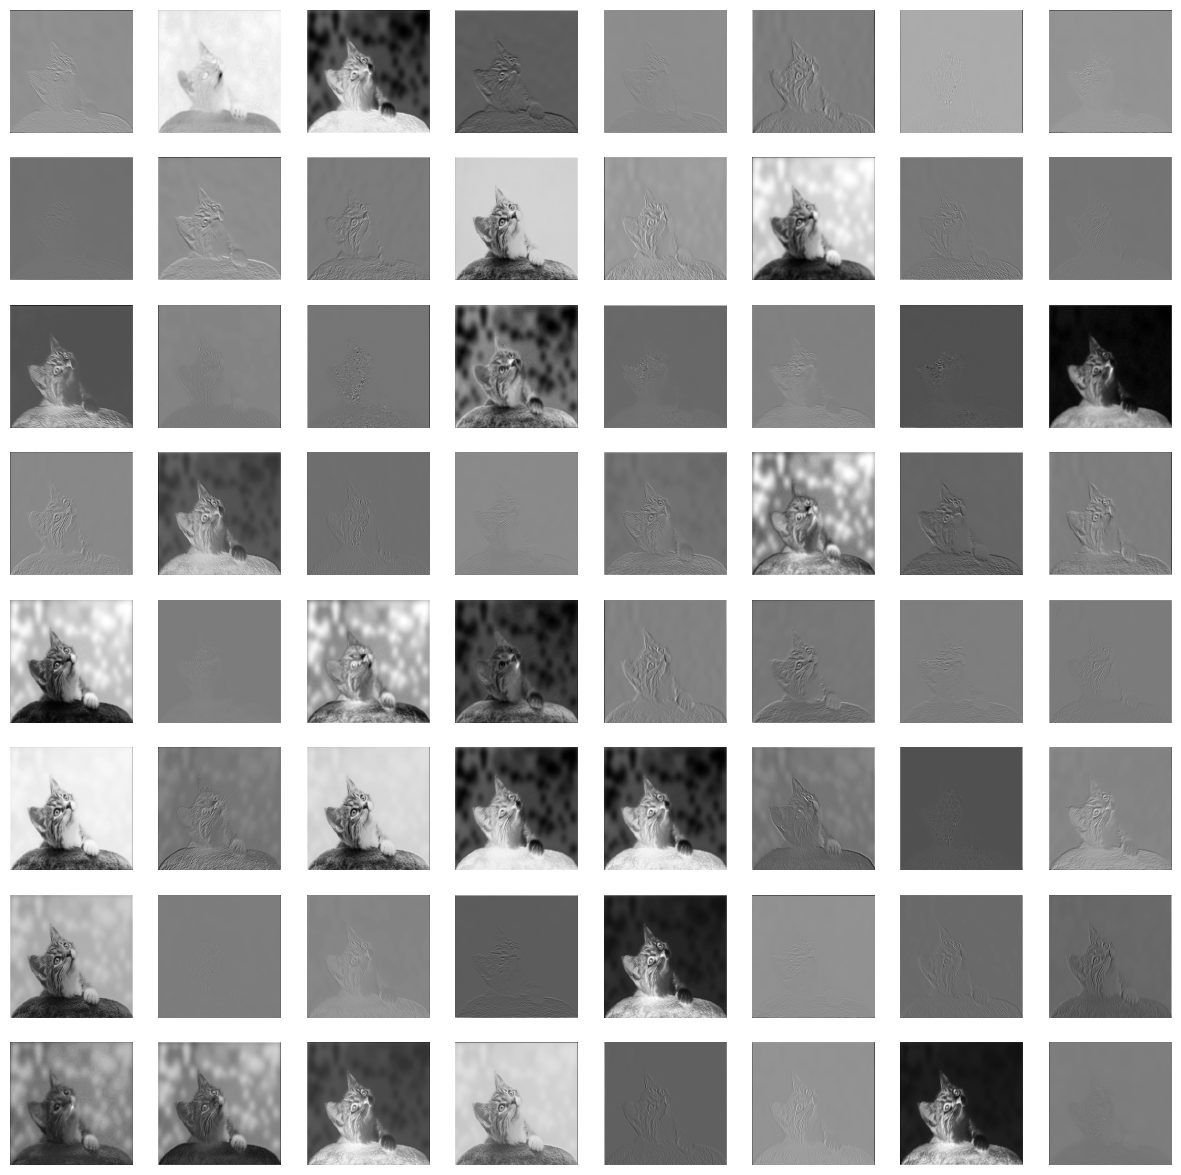

In [8]:
# visualize the first layer
visualize_deep(outputs, 0)

The feature map from the first convolutional layer is shown in the figure above (layer 0). As can be seen, various filters focus on different features while building an image's feature map. Some feature maps concentrate on the image's backdrop. Others draw an outline of the image. A couple filters generate feature maps with a dark background but a brilliant picture of the cat. This is due to the filters' associated weights. The above image clearly shows that the neural network sees very detailed feature maps of the input image in the deep layers.

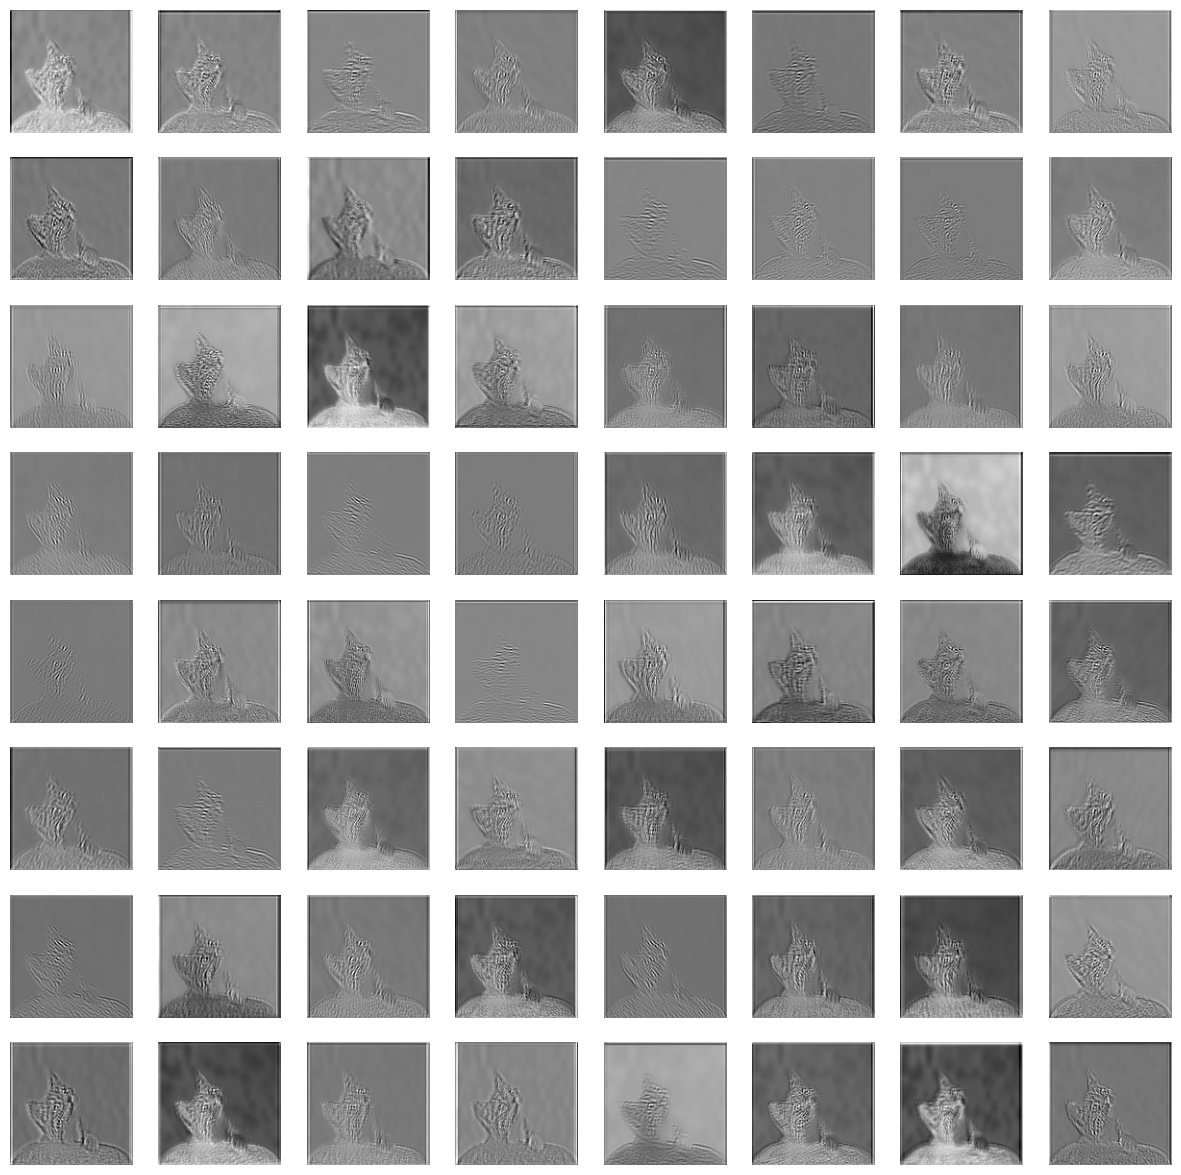

In [9]:
# visualize a deeper layer
visualize_deep(outputs, 20)

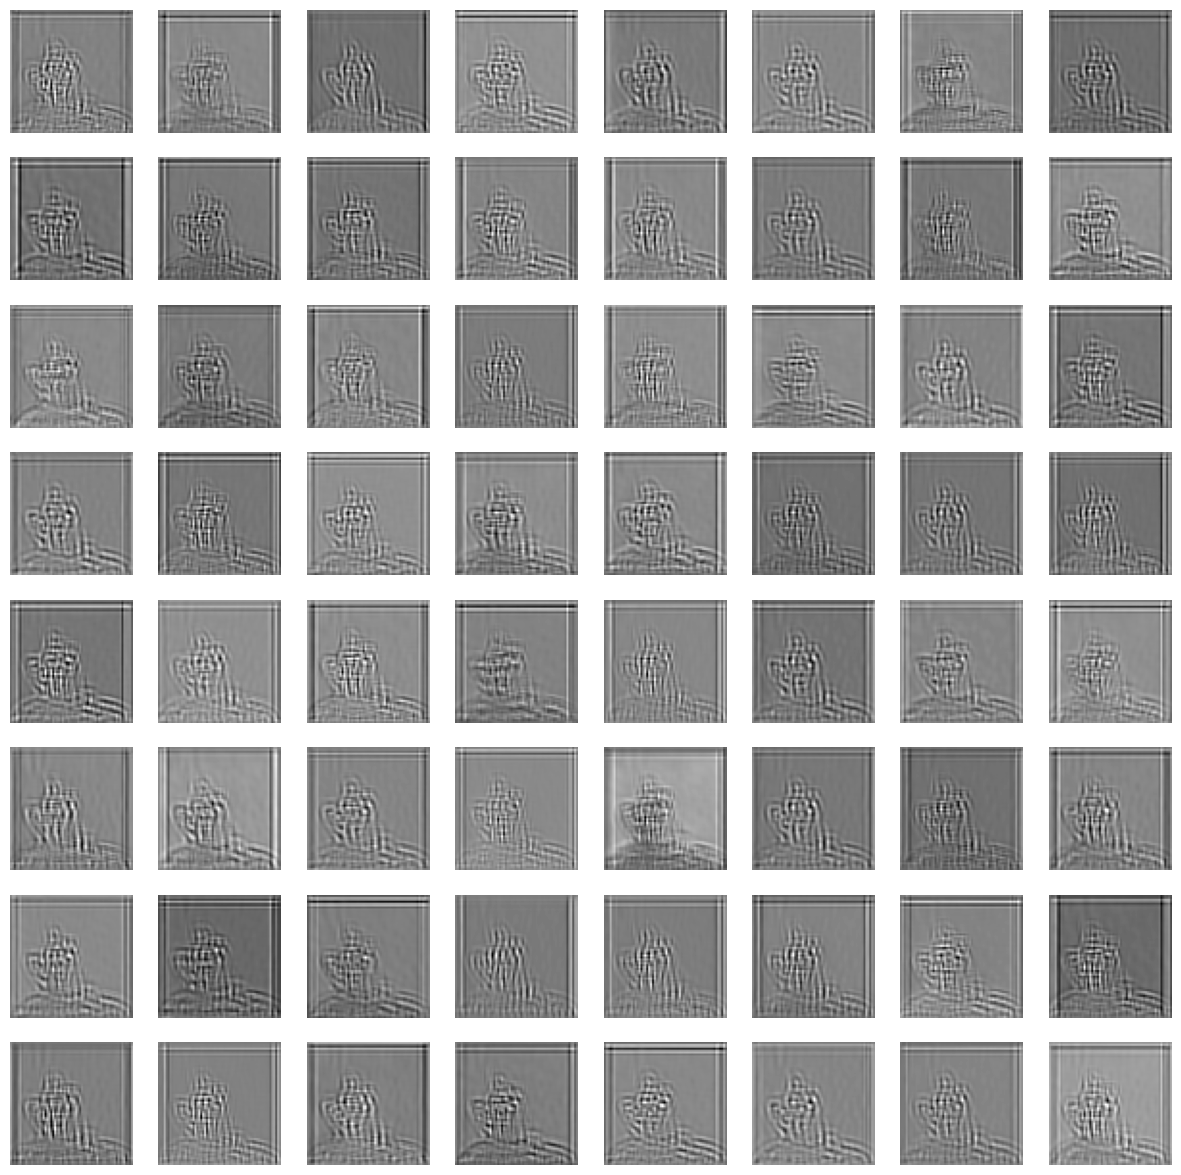

In [10]:
visualize_deep(outputs, 40)

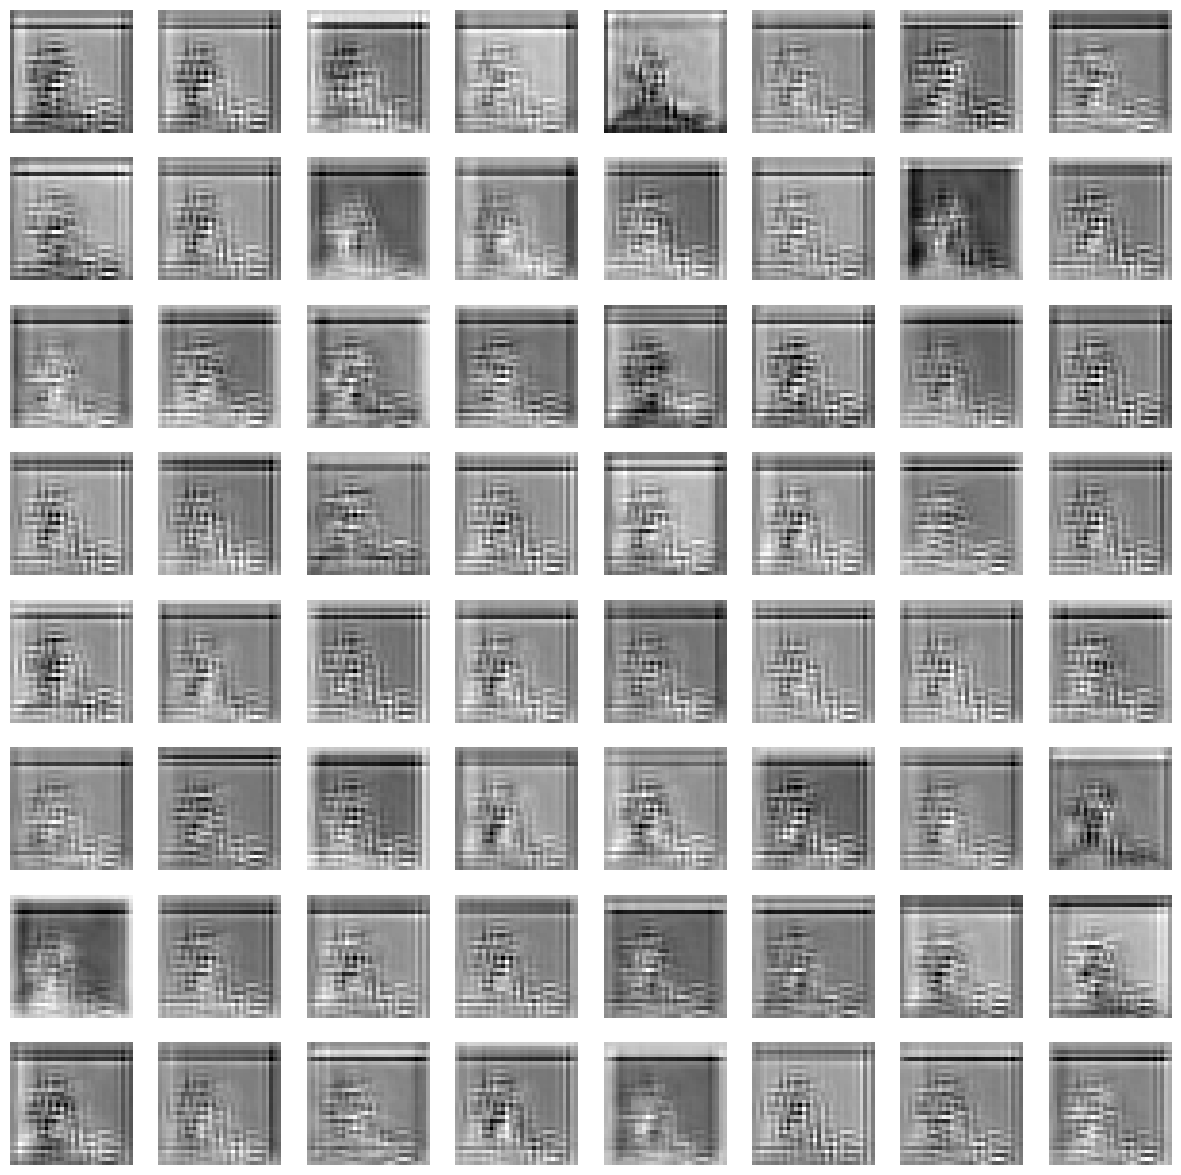

In [11]:
visualize_deep(outputs, 48)

As the picture proceeds through the layers, the details from the photographs gradually fade away. They appear to be noise, but there is undoubtedly a pattern in those feature maps that human eyes cannot identify, but a neural network can.

It is difficult for a human to determine that there is a cat in the image by the time it reaches the last convolutional layer (layer 48). These last layer outputs are critical for the fully connected neurons that comprise the classification layers in a convolutional neural network.